In [50]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import random

In [28]:
# Load and preprocess the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [29]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

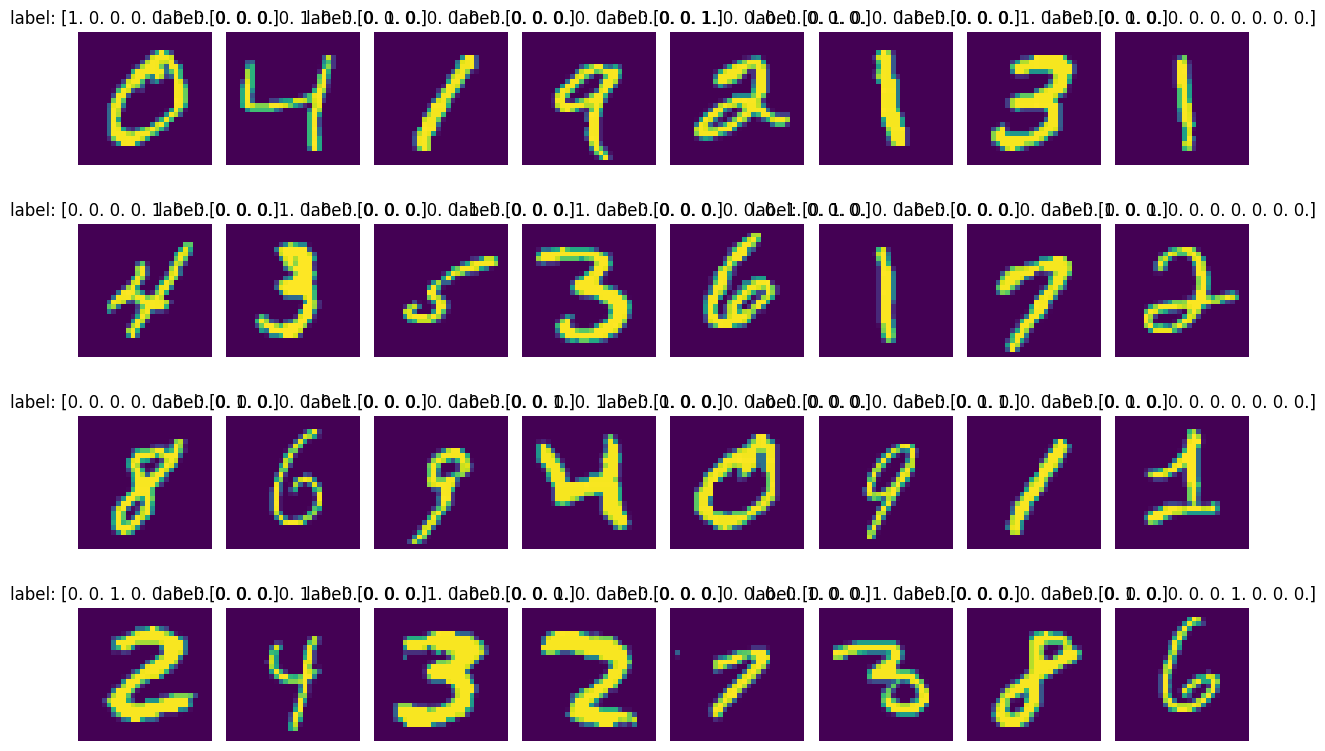

In [54]:
num_rows, num_cols = 4, 8
num_images = num_rows * num_cols
plt.figure(figsize=(12, 8))
for i in range(1, num_images + 1):
    plt.subplot(num_rows, num_cols, i)
    plt.imshow(x_train[i], cmap='viridis')
    plt.title(f"label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [31]:
x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0

In [32]:
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

In [33]:
# Define the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [34]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [36]:
history = model.fit(datagen.flow(np.expand_dims(x_train, axis=-1), y_train, batch_size=32),
                    epochs=5,
                    validation_data=(np.expand_dims(x_val, axis=-1), y_val))
test_loss, test_acc = model.evaluate(np.expand_dims(x_test, axis=-1), y_test)
print(f"Test accuracy: {test_acc}")

Epoch 1/5
1875/1875 [==============================] - 88s 46ms/step - loss: 0.2846 - accuracy: 0.9102 - val_loss: 0.0570 - val_accuracy: 0.9816
Epoch 2/5
1875/1875 [==============================] - 83s 44ms/step - loss: 0.1004 - accuracy: 0.9695 - val_loss: 0.0350 - val_accuracy: 0.9885
Epoch 3/5
1875/1875 [==============================] - 84s 45ms/step - loss: 0.0744 - accuracy: 0.9766 - val_loss: 0.0299 - val_accuracy: 0.9912
Epoch 4/5
1875/1875 [==============================] - 83s 44ms/step - loss: 0.0638 - accuracy: 0.9803 - val_loss: 0.0369 - val_accuracy: 0.9881
Epoch 5/5
313/313 [==============================] - 4s 12ms/step - loss: 0.0248 - accuracy: 0.9924
Test accuracy: 0.9923999905586243


In [37]:
# Define the grid search parameters
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'activation': ['relu', 'tanh'],
    'batch_size': [32, 64],
    'epochs': [5, 10]
}

In [56]:
param_combinations = list(itertools.product(param_grid['optimizer'],
                                            param_grid['activation'],
                                            param_grid['batch_size'],
                                            param_grid['epochs']))
best_accuracy = 0
best_params = None

In [45]:
# Perform grid search
def create_model(optimizer, activation):
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation=activation),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

for params in param_combinations:
    optimizer, activation, batch_size, epochs = params
    print(f"Training with params: optimizer={optimizer}, activation={activation}, batch_size={batch_size}, epochs={epochs}")

    model = create_model(optimizer, activation)

    history = model.fit(
        datagen.flow(np.expand_dims(x_train, axis=-1), y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=(np.expand_dims(x_val, axis=-1), y_val),
        verbose=0
    )
    val_accuracy = max(history.history['val_accuracy'])

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = params


Training with params: optimizer=adam, activation=relu, batch_size=32, epochs=5
Training with params: optimizer=adam, activation=relu, batch_size=32, epochs=10
Training with params: optimizer=adam, activation=relu, batch_size=64, epochs=5
Training with params: optimizer=adam, activation=relu, batch_size=64, epochs=10
Training with params: optimizer=adam, activation=tanh, batch_size=32, epochs=5
Training with params: optimizer=adam, activation=tanh, batch_size=32, epochs=10
Training with params: optimizer=adam, activation=tanh, batch_size=64, epochs=5
Training with params: optimizer=adam, activation=tanh, batch_size=64, epochs=10
Training with params: optimizer=rmsprop, activation=relu, batch_size=32, epochs=5
Training with params: optimizer=rmsprop, activation=relu, batch_size=32, epochs=10
Training with params: optimizer=rmsprop, activation=relu, batch_size=64, epochs=5
Training with params: optimizer=rmsprop, activation=relu, batch_size=64, epochs=10
Training with params: optimizer=rm

In [46]:
print(f"Best validation accuracy: {best_accuracy} with parameters: {best_params}")
optimizer, activation, batch_size, epochs = best_params
best_model = create_model(optimizer, activation)
best_model.fit(datagen.flow(np.expand_dims(x_train, axis=-1), y_train, batch_size=batch_size),
               epochs=epochs,
               validation_data=(np.expand_dims(x_val, axis=-1), y_val),
               verbose=0)
test_loss, test_acc = best_model.evaluate(np.expand_dims(x_test, axis=-1), y_test)
print(f"Test accuracy: {test_acc}")

Best validation accuracy: 0.9790833592414856 with parameters: ('adam', 'tanh', 32, 10)
313/313 [==============================] - 1s 2ms/step - loss: 0.0767 - accuracy: 0.9757
Test accuracy: 0.9757000207901001


In [55]:
n_random_searches = 10
def sample_params(param_grid):
    return {key: random.choice(values) for key, values in param_grid.items()}

best_accuracy = 0
best_params = None

In [52]:
# Perform random search
for _ in range(n_random_searches):
    params = sample_params(param_grid)
    optimizer = params['optimizer']
    activation = params['activation']
    batch_size = params['batch_size']
    epochs = params['epochs']

    print(f"Training with params: optimizer={optimizer}, activation={activation}, batch_size={batch_size}, epochs={epochs}")

    model = create_model(optimizer, activation)

    history = model.fit(
        datagen.flow(np.expand_dims(x_train, axis=-1), y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=(np.expand_dims(x_val, axis=-1), y_val),
        verbose=0
    )

    val_accuracy = max(history.history['val_accuracy'])

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = params

Training with params: optimizer=rmsprop, activation=relu, batch_size=32, epochs=5
Training with params: optimizer=adam, activation=relu, batch_size=64, epochs=5
Training with params: optimizer=adam, activation=tanh, batch_size=64, epochs=10
Training with params: optimizer=adam, activation=tanh, batch_size=64, epochs=5
Training with params: optimizer=adam, activation=relu, batch_size=64, epochs=5
Training with params: optimizer=adam, activation=relu, batch_size=64, epochs=5
Training with params: optimizer=rmsprop, activation=tanh, batch_size=64, epochs=10
Training with params: optimizer=rmsprop, activation=tanh, batch_size=64, epochs=10
Training with params: optimizer=rmsprop, activation=tanh, batch_size=64, epochs=5
Training with params: optimizer=rmsprop, activation=tanh, batch_size=32, epochs=5


In [53]:
# Print the best parameters and best validation accuracy
print(f"Best validation accuracy: {best_accuracy} with parameters: {best_params}")
optimizer = best_params['optimizer']
activation = best_params['activation']
batch_size = best_params['batch_size']
epochs = best_params['epochs']
best_model = create_model(optimizer, activation)
best_model.fit(datagen.flow(np.expand_dims(x_train, axis=-1), y_train, batch_size=batch_size),
               epochs=epochs,
               validation_data=(np.expand_dims(x_val, axis=-1), y_val),
               verbose=0)
test_loss, test_acc = best_model.evaluate(np.expand_dims(x_test, axis=-1), y_test)
print(f"Test accuracy: {test_acc}")

Best validation accuracy: 0.9775000214576721 with parameters: {'optimizer': 'adam', 'activation': 'tanh', 'batch_size': 64, 'epochs': 10}
313/313 [==============================] - 1s 2ms/step - loss: 0.0762 - accuracy: 0.9761
Test accuracy: 0.9761000275611877
